In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sc

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score

from xgboost import XGBClassifier

### Importa las librerías necesarias para entrenar modelos de regresión logística con validación cruzada y Extreme Gradient Boosting, carga los datos y prepáralos.

In [2]:
data = pd.read_csv('hcvdat0.csv') #importamos el DF

In [3]:
data.info() #vemos caracteristicas principales de las columnas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  615 non-null    int64  
 1   Category    615 non-null    object 
 2   Age         615 non-null    int64  
 3   Sex         615 non-null    object 
 4   ALB         614 non-null    float64
 5   ALP         597 non-null    float64
 6   ALT         614 non-null    float64
 7   AST         615 non-null    float64
 8   BIL         615 non-null    float64
 9   CHE         615 non-null    float64
 10  CHOL        605 non-null    float64
 11  CREA        615 non-null    float64
 12  GGT         615 non-null    float64
 13  PROT        614 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 67.4+ KB


- tenemos 14 columnas
- dos columnas son de tipo object
- el resto de las columnas son tipo float/integer
- varias columnas tienen datos faltantes

In [4]:
data.head(5)

,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,1,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,2,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,3,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,4,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,5,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


In [5]:
data = data.drop(columns='Unnamed: 0') #eliminamos la columna unnamed

### Transformar columna Category

In [6]:
data['Category'].value_counts()

Category
0=Blood Donor             533
3=Cirrhosis                30
1=Hepatitis                24
2=Fibrosis                 21
0s=suspect Blood Donor      7
Name: count, dtype: int64

In [7]:
data['target'] = np.where((data['Category'] == '0=Blood Donor'), 0, 1) #creamos una columna target y asignamos valor 1 para donors de sangre
data['suspect'] = np.where((data['Category'] == '0s=suspect Blood Donor'), 1, 0) #creamos una columna para guardar donors potenciales

In [8]:
data = data.drop(columns='Category')

In [9]:
data['Sex'] = np.where(data['Sex'] == 'm', 1, 0) #recodificamos la columna sex

In [10]:
#buscamos los atributos con menos de 1% de datos faltantes y con datos faltantes mas de 1%
atributos_na_eliminar = []
atributos_na_rellenar = []
for columna in data.columns:
    if (data[columna].isna().sum()/data.shape[0]*100) < 1:
        atributos_na_eliminar.append(columna)
    elif ((data[columna].isna().sum())/data.shape[0]*100) >= 1:
        atributos_na_rellenar.append(columna)


print(atributos_na_eliminar)
print(atributos_na_rellenar)

['Age', 'Sex', 'ALB', 'ALT', 'AST', 'BIL', 'CHE', 'CREA', 'GGT', 'PROT', 'target', 'suspect']
['ALP', 'CHOL']


In [11]:
data_clean = data.dropna(axis = 0, subset = atributos_na_eliminar) #eliminamos los NA de las columnas con menos de 1% de datos faltantes

In [12]:
#rellenamos los datos faltantes segun las instrucciones con los promedios de clase y dependiendo del tipo de variable
for columna in atributos_na_rellenar:
    data_clean[columna] = data_clean[columna].astype(float)
    promedio_target_cero = data_clean[columna][data_clean['target']== 0].mean()
    promedio_target_uno =  data_clean[columna][data_clean['target']== 1].mean()
   
    data_clean[columna].loc[data_clean['target']== 0] = data_clean[columna].loc[data_clean['target']== 0].fillna(promedio_target_cero)
    data_clean[columna].loc[data_clean['target']== 1] = data_clean[columna].loc[data_clean['target']== 1].fillna(promedio_target_uno)

/var/folders/jg/_1ls91ln31d5ft8m5pg9xq_h0000gn/T/ipykernel_29672/1266930948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean[columna] = data_clean[columna].astype(float)
/var/folders/jg/_1ls91ln31d5ft8m5pg9xq_h0000gn/T/ipykernel_29672/1266930948.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean[columna].loc[data_clean['target']== 0] = data_clean[columna].loc[data_clean['target']== 0].fillna(promedio_target_cero)
/var/folders/jg/_1ls91ln31d5ft8m5pg9xq_h0000gn/T/ipykernel_29672/1266930948.py:8: SettingWithCopyWarning: 
A value is trying t

In [13]:
data.describe()

,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,target,suspect
count,615.000000,615.000000,614.000000,597.000000,614.000000,615.000000,615.000000,615.000000,605.000000,615.000000,615.000000,614.000000,615.000000,615.000000
mean,47.408130,0.613008,41.620195,68.283920,28.450814,34.786341,11.396748,8.196634,5.368099,81.287805,39.533171,72.044137,0.133333,0.011382
std,10.055105,0.487458,5.780629,26.028315,25.469689,33.090690,19.673150,2.205657,1.132728,49.756166,54.661071,5.402636,0.340211,0.106164
min,19.000000,0.000000,14.900000,11.300000,0.900000,10.600000,0.800000,1.420000,1.430000,8.000000,4.500000,44.800000,0.000000,0.000000
25%,39.000000,0.000000,38.800000,52.500000,16.400000,21.600000,5.300000,6.935000,4.610000,67.000000,15.700000,69.300000,0.000000,0.000000
50%,47.000000,1.000000,41.950000,66.200000,23.000000,25.900000,7.300000,8.260000,5.300000,77.000000,23.300000,72.200000,0.000000,0.000000
75%,54.000000,1.000000,45.200000,80.100000,33.075000,32.900000,11.200000,9.590000,6.060000,88.000000,40.200000,75.400000,0.000000,0.000000
max,77.000000,1.000000,82.200000,416.600000,325.300000,324.000000,254.000000,16.410000,9.670000,1079.100000,650.900000,90.000000,1.000000,1.000000


In [14]:
columnas_categoricas = ['Sex', 'suspect', 'target'] #creamos dos listas: columnas categoricas y numericas

In [15]:
columnas_numericas = list((data_clean.drop(columns = columnas_categoricas)).columns)

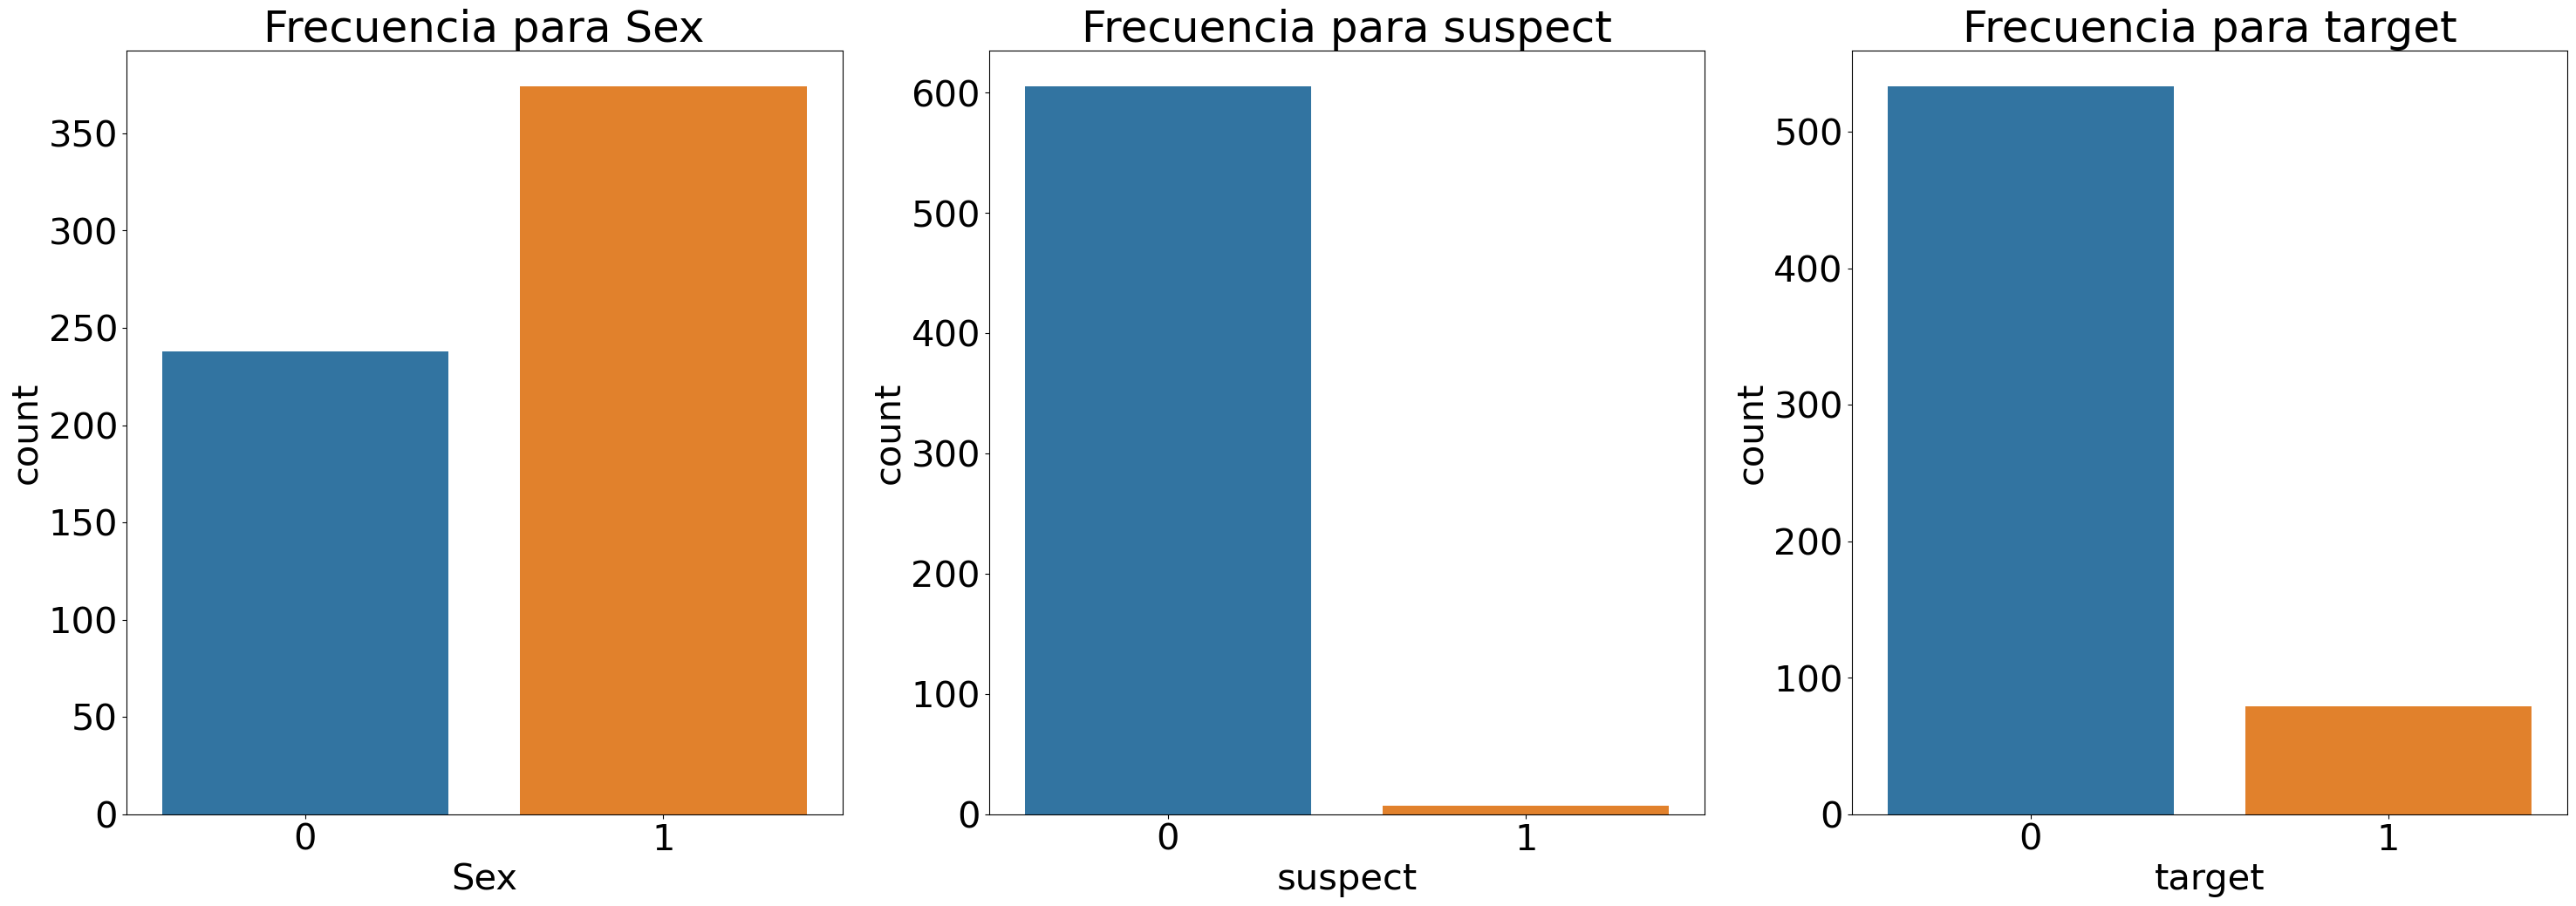

In [16]:
#graficamos las variables categoricas
plt.rcParams.update({'font.size': 30})
plt.figure(figsize=(30, 30))
for n, i in enumerate(columnas_categoricas):
    plt.subplot(3, 3, n+1)
    sns.countplot(x = data_clean[i])
    plt.title('Frecuencia para {}'.format(i))
    plt.tight_layout(pad=0.8)

- hay muy pocos datos de donors potenciales
- target tiene mucho mas valores de donors que de los que no pueden donar

In [17]:
data_clean[columnas_numericas].corr()

,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
Age,1.000000,-0.199953,0.168295,-0.007046,0.088178,0.040160,-0.074764,0.121320,-0.021683,0.150489,-0.160994
ALB,-0.199953,1.000000,-0.140005,0.009789,-0.181928,-0.170567,0.363820,0.208857,0.002534,-0.146497,0.560239
ALP,0.168295,-0.140005,1.000000,0.171322,0.061958,0.055821,0.033804,0.123516,0.149671,0.443403,-0.055613
ALT,-0.007046,0.009789,0.171322,1.000000,0.269540,-0.075155,0.155223,0.063173,-0.044359,0.244663,0.093914
AST,0.088178,-0.181928,0.061958,0.269540,1.000000,0.306612,-0.198990,-0.212056,-0.023837,0.487421,0.038863
BIL,0.040160,-0.170567,0.055821,-0.075155,0.306612,1.000000,-0.315819,-0.180591,0.020782,0.208957,-0.048705
CHE,-0.074764,0.363820,0.033804,0.155223,-0.198990,-0.315819,1.000000,0.424361,-0.008008,-0.101588,0.299027
CHOL,0.121320,0.208857,0.123516,0.063173,-0.212056,-0.180591,0.424361,1.000000,-0.047414,-0.010010,0.209080
CREA,-0.021683,0.002534,0.149671,-0.044359,-0.023837,0.020782,-0.008008,-0.047414,1.000000,0.120016,-0.031530
GGT,0.150489,-0.146497,0.443403,0.244663,0.487421,0.208957,-0.101588,-0.010010,0.120016,1.000000,-0.015471


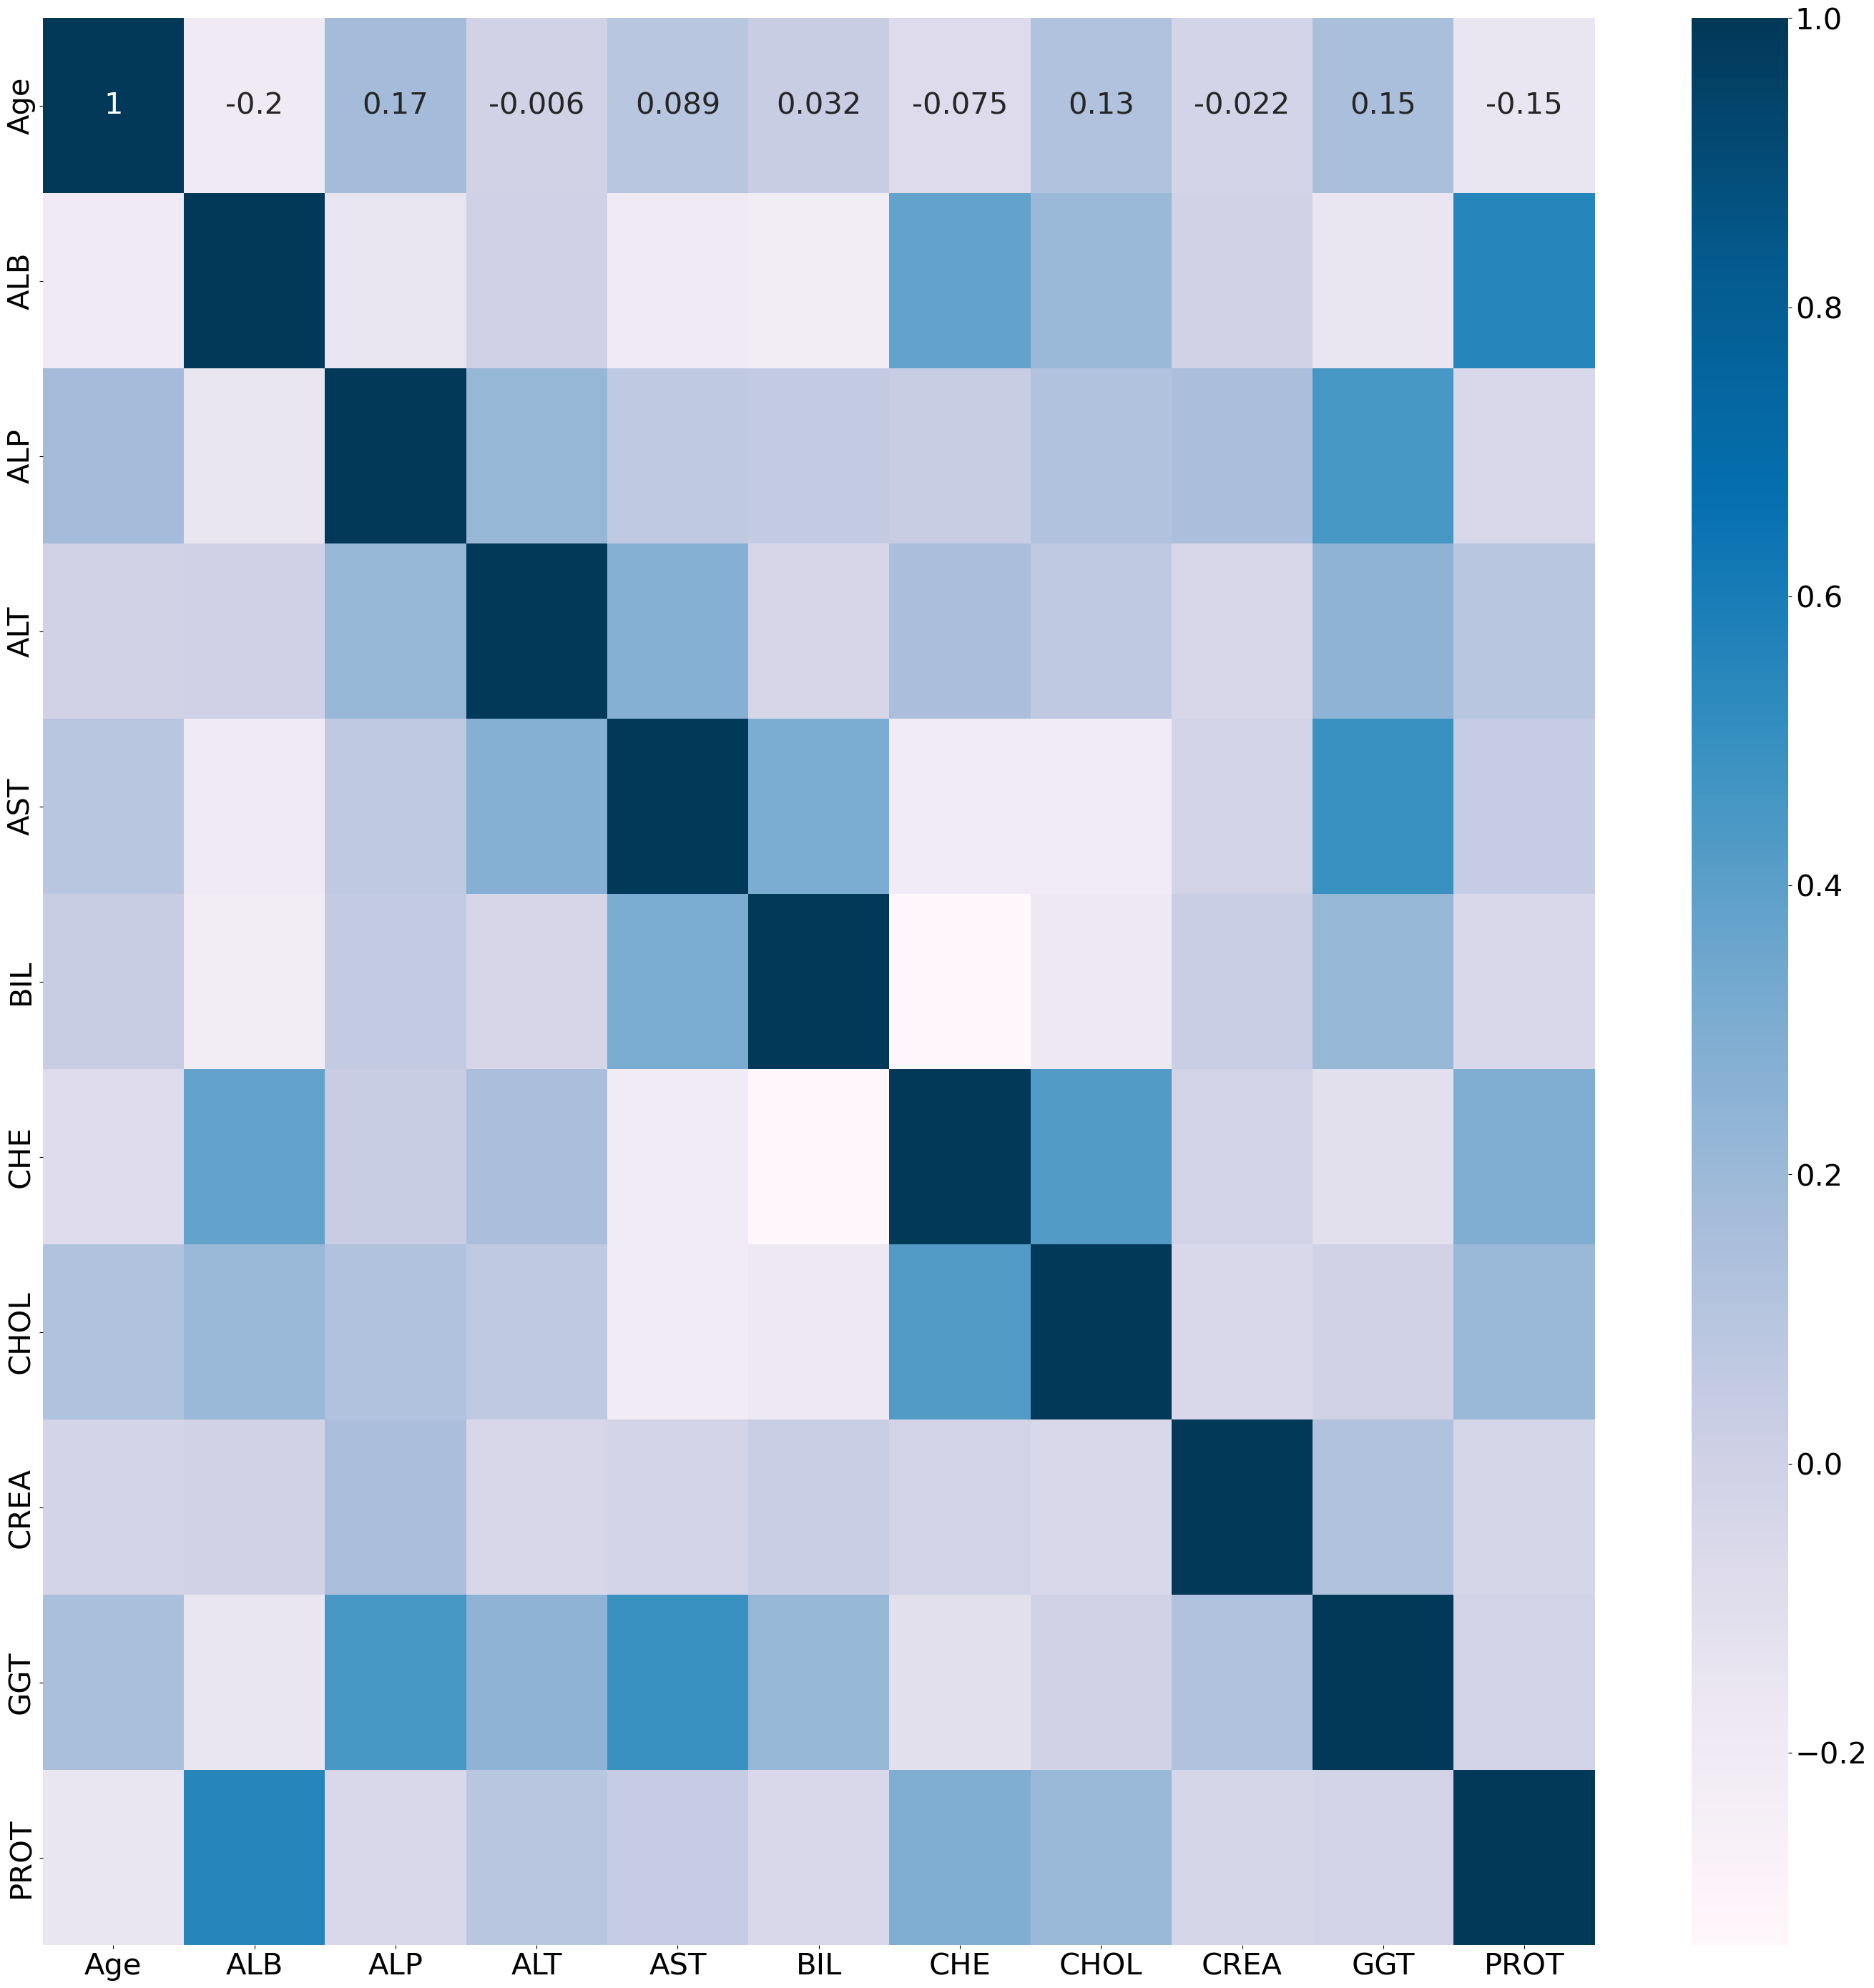

In [18]:
#creamos un heatmap con correlaciones entre las variables.
plt.figure(figsize=(35,35))
sns.heatmap(data[columnas_numericas].corr(), annot=True, cmap=plt.cm.PuBu)
plt.show()

- no hay correlaciones muy altas que podrian afectar los resultados
- hay una correlacion de 0.56 entre las variables de proteinas totales y de albumina, lo que tiene sentido dado que las dos representan niveles de diferentes proteinas
- las variables GGT y ALB tienen una correlacion de 0.44, las dos variables pueden indicar la funcion hepática

/var/folders/jg/_1ls91ln31d5ft8m5pg9xq_h0000gn/T/ipykernel_29672/1134764619.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_clean[i])
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/jg/_1ls91ln31d5ft8m5pg9xq_h0000gn/T/ipykernel_29672/1134764619.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level f

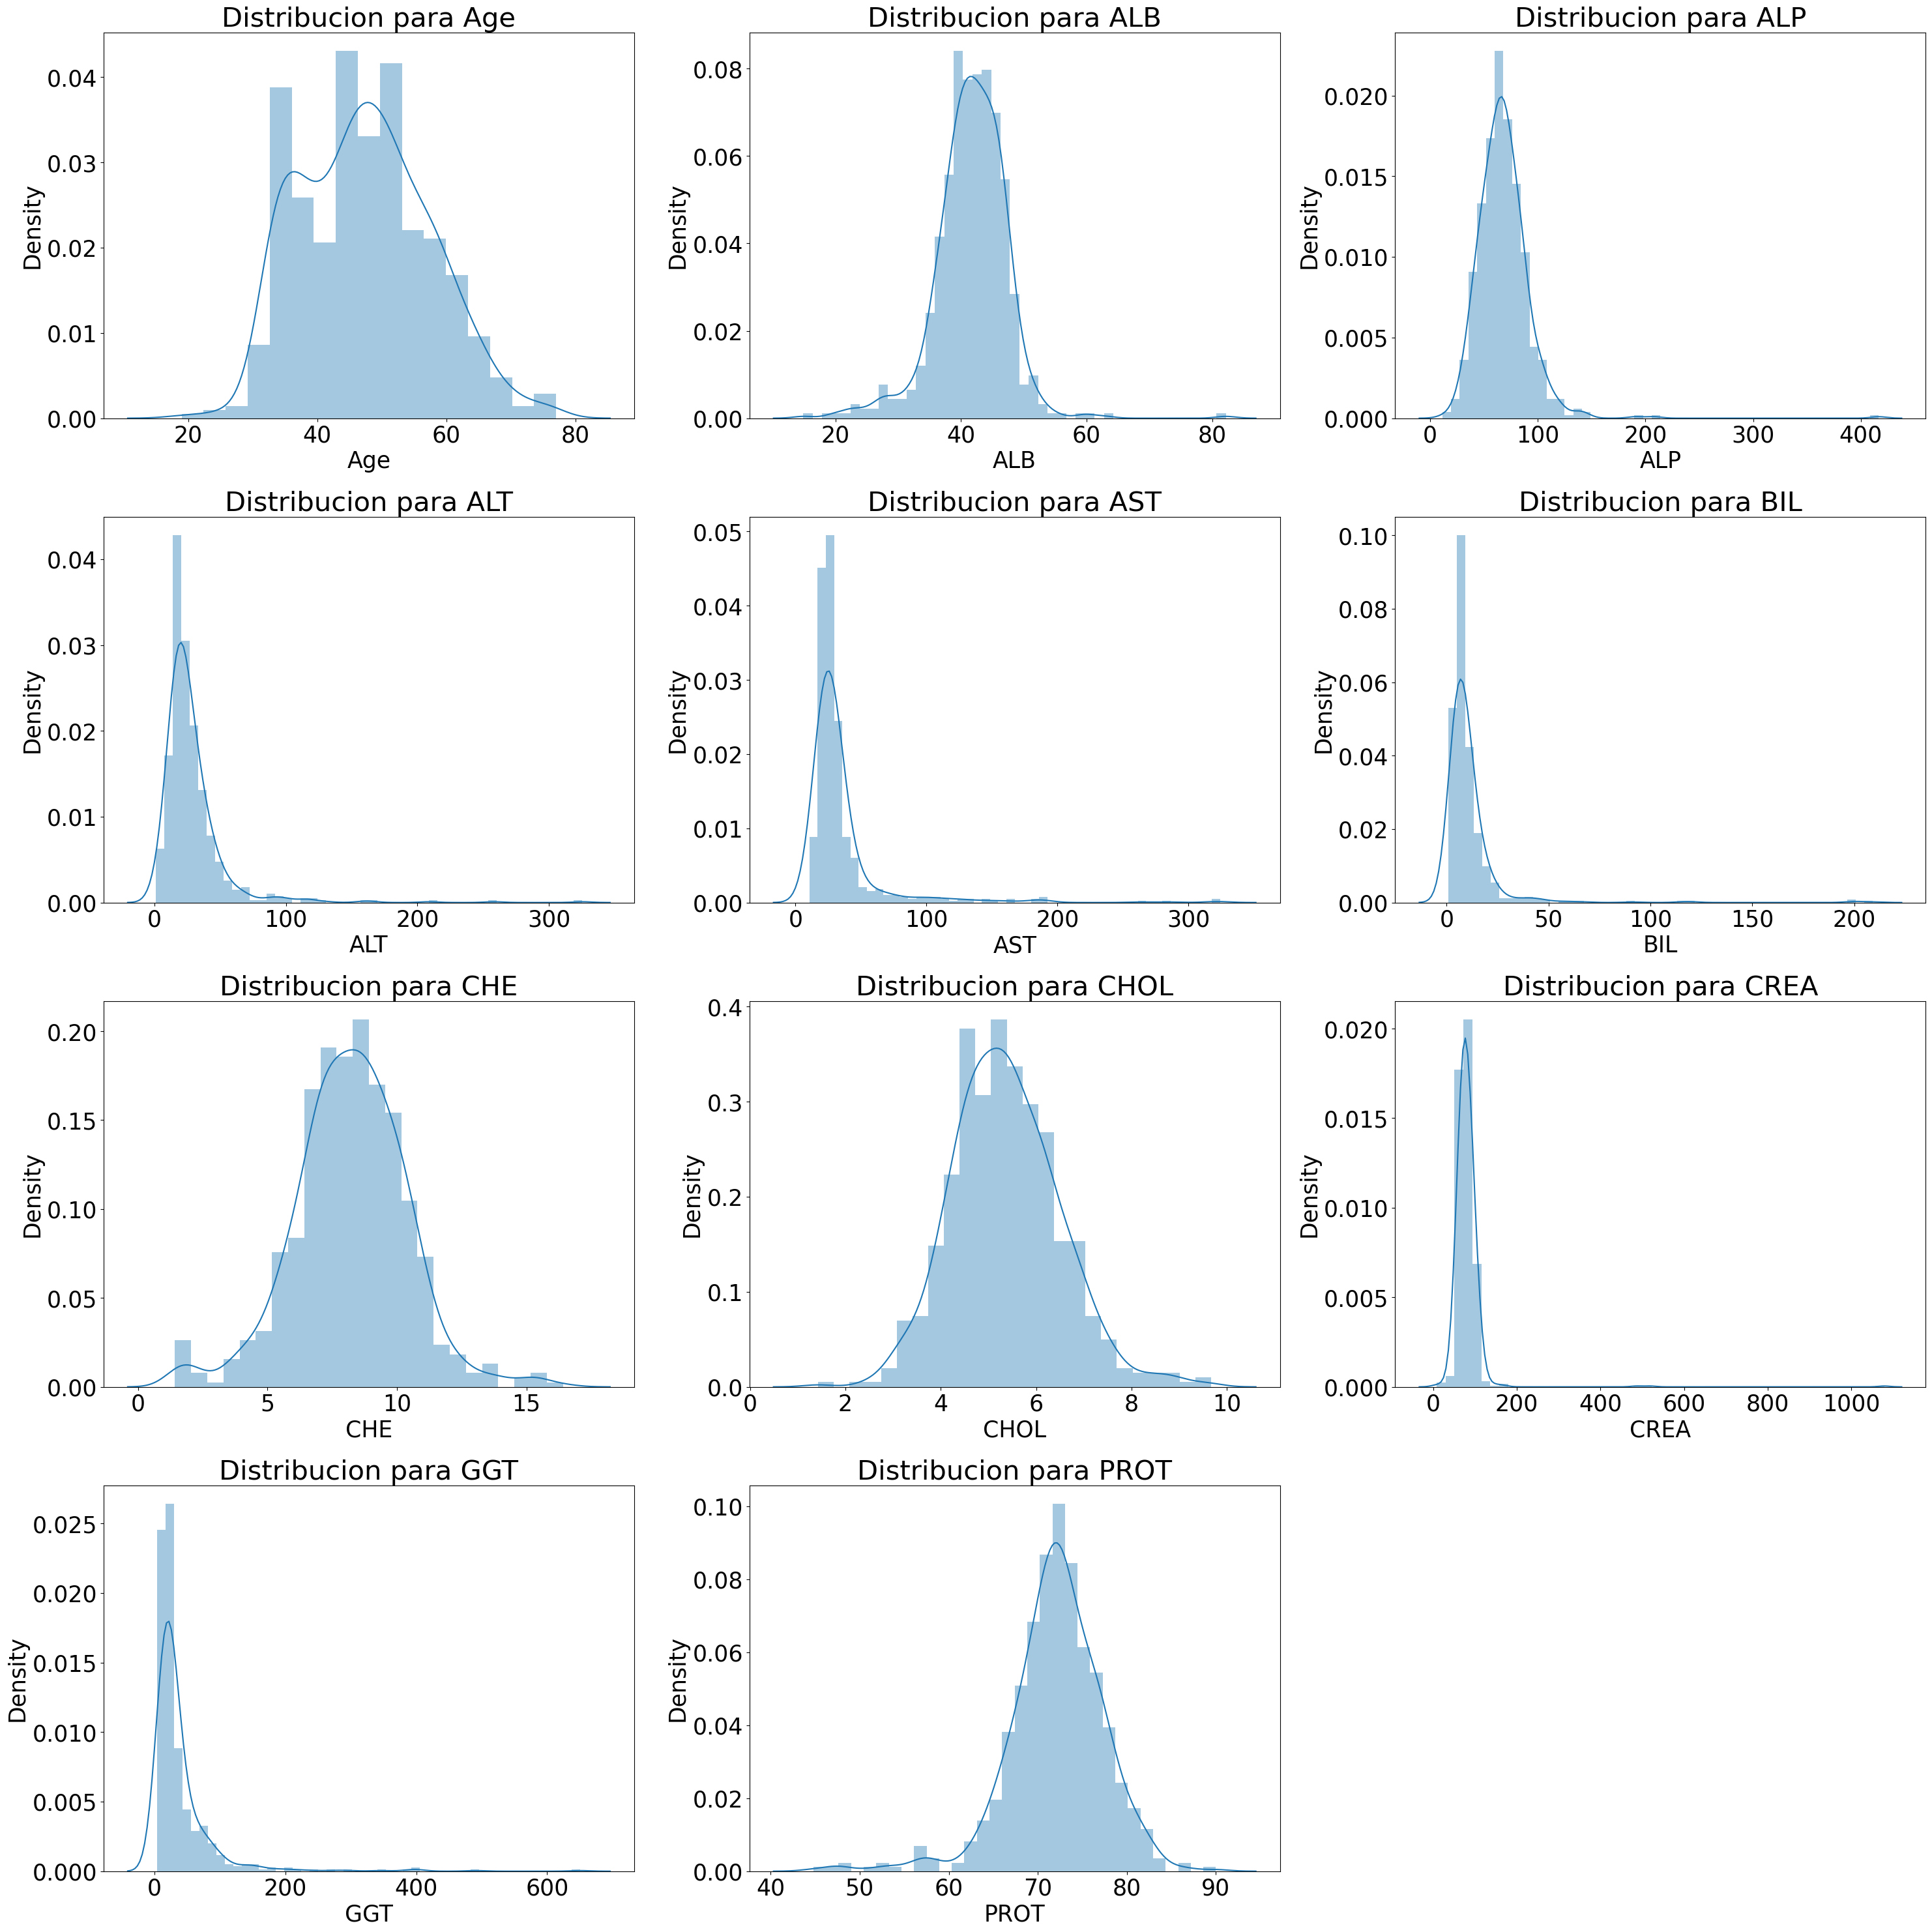

In [19]:
#graficamos la distribucion para las variables continuas
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(30, 30))
for n, i in enumerate(columnas_numericas):
    plt.subplot(4, 3, n+1)
    sns.distplot(data_clean[i])
    plt.title('Distribucion para {}'.format(i))
    plt.tight_layout(pad=0.8)

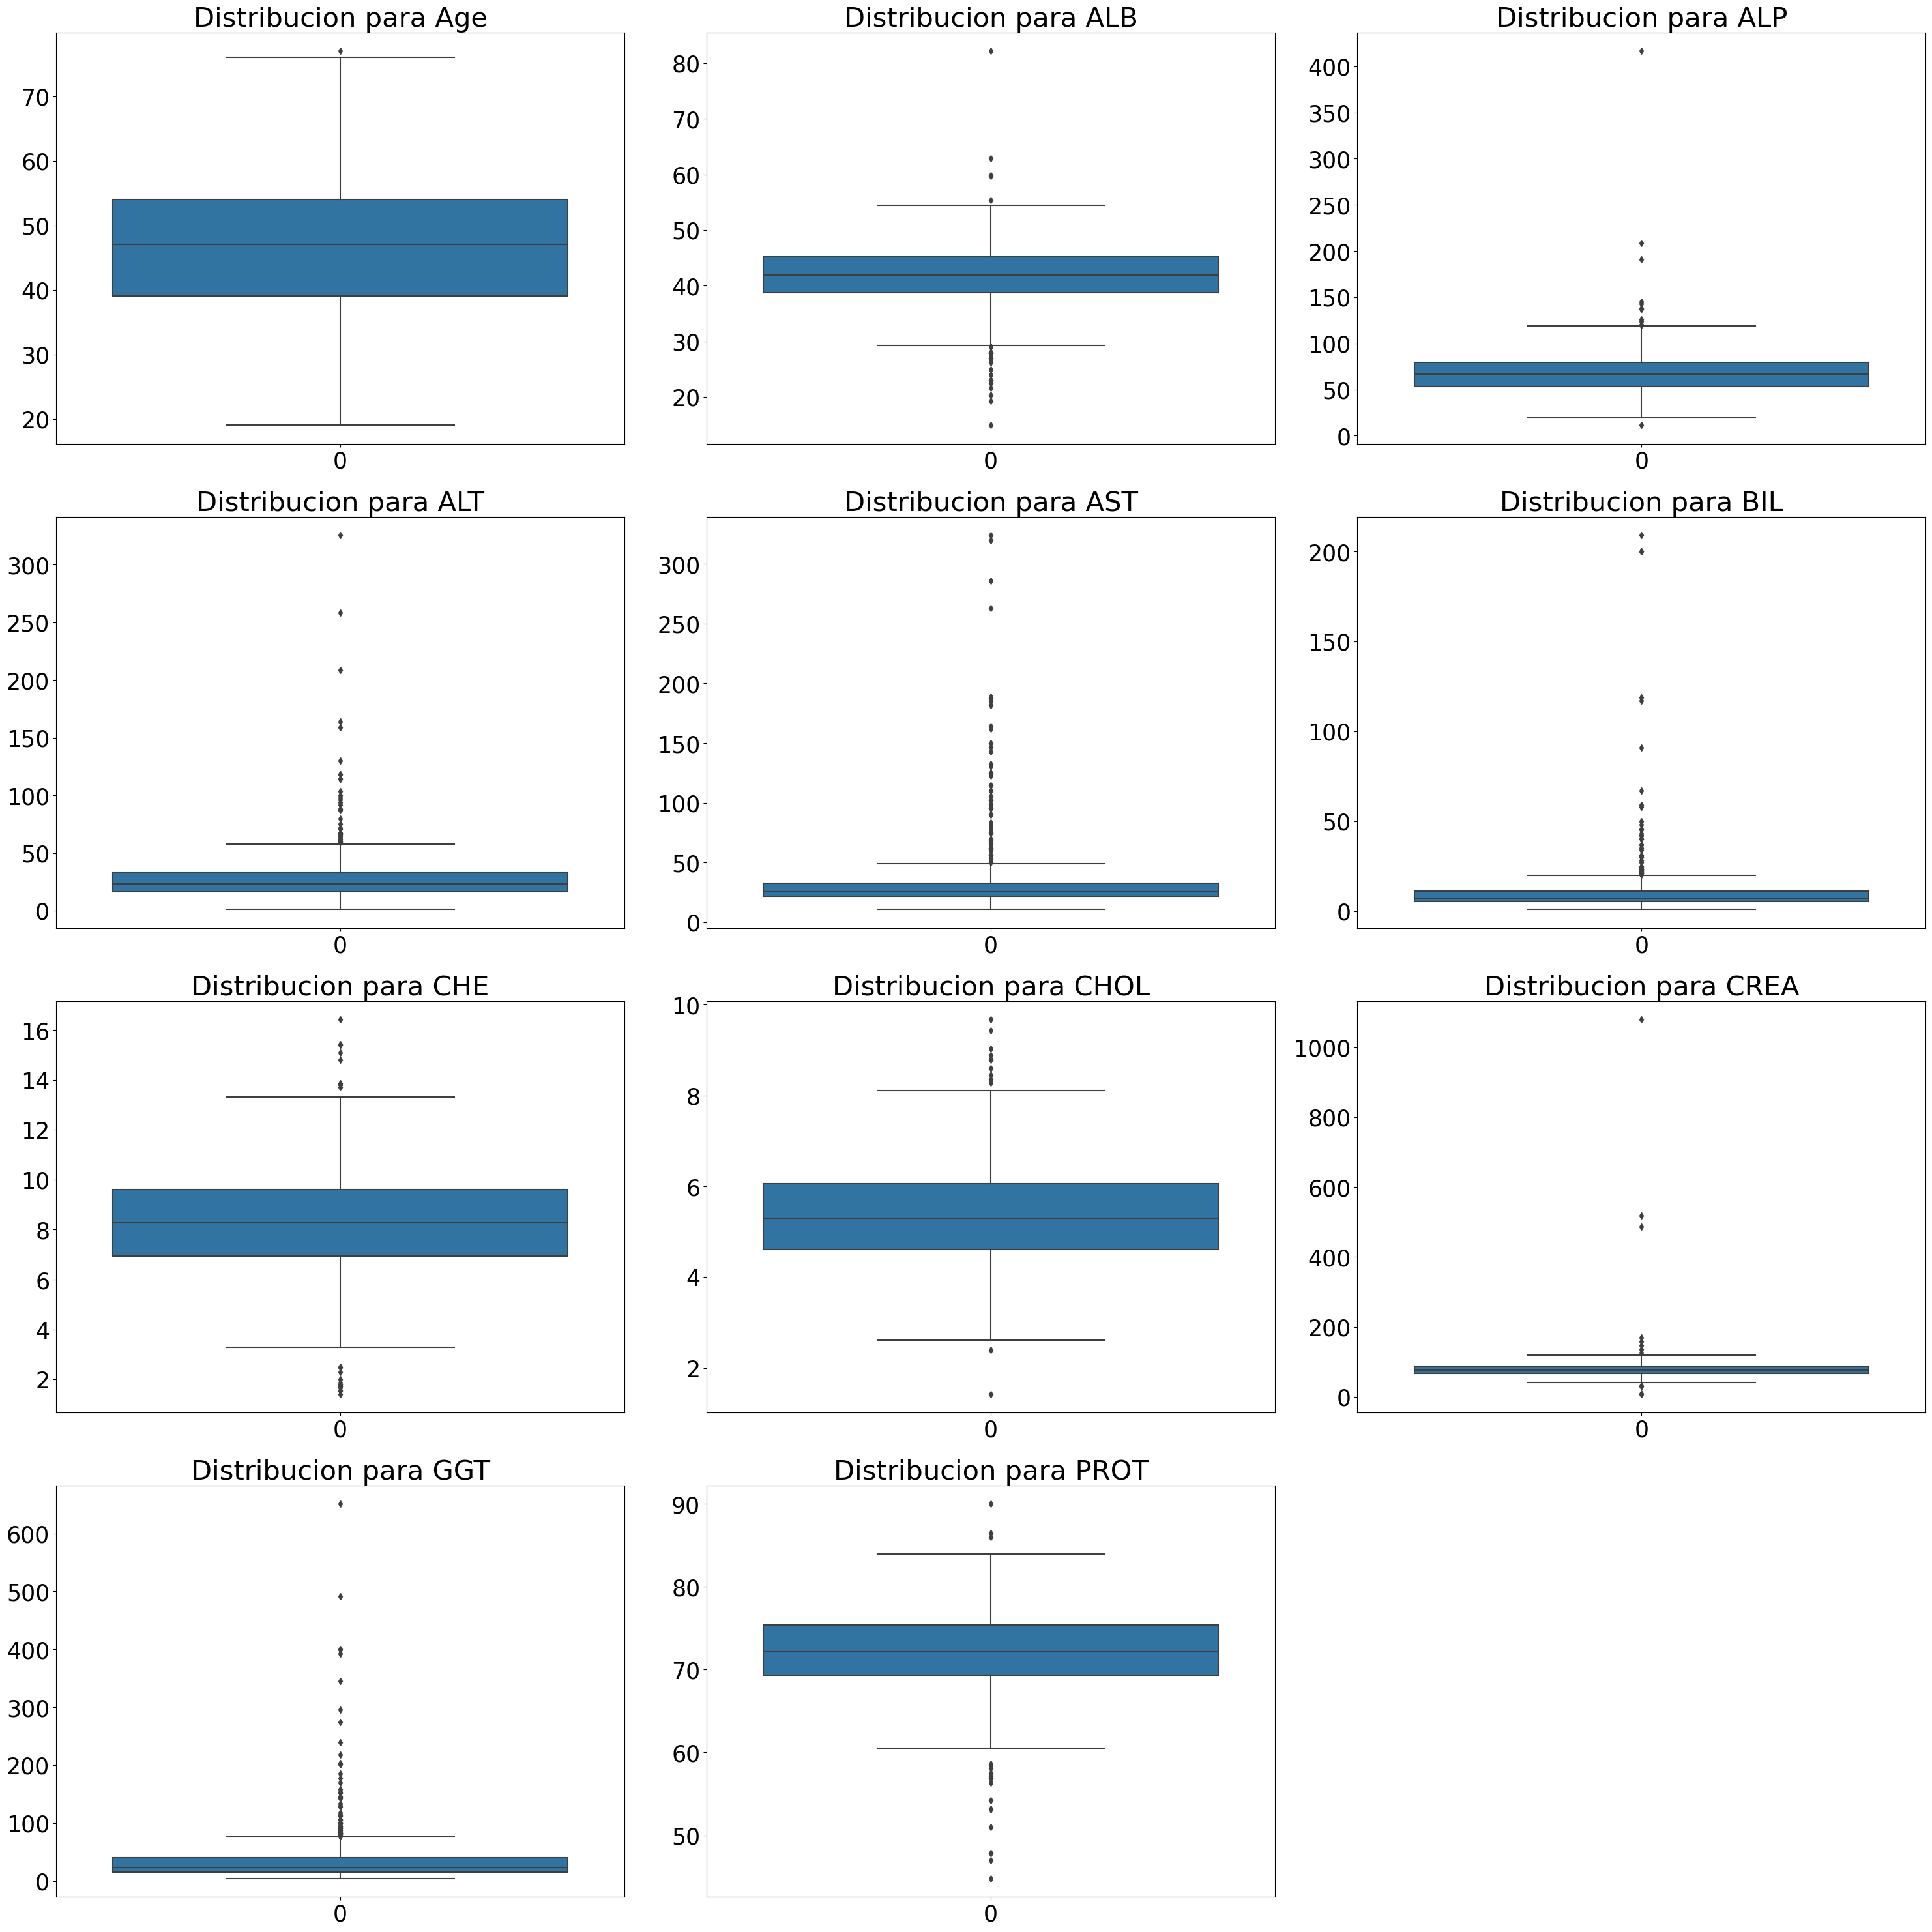

In [20]:
#graficamos los boxplots para las variables continuas
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(30, 30))
for n, i in enumerate(columnas_numericas):
    plt.subplot(4, 3, n+1)
    sns.boxplot(data_clean[i])
    plt.title('Distribucion para {}'.format(i))
    plt.tight_layout(pad=0.8)
    

- las distribuciones se parecen a las normales, pero en la mayoria de las variables tiene valores extremos (colas largas)
- serviria aplicar la funcion logaritmica para normalizar los datos
- es necesario escalar la data

In [21]:
for columna in columnas_numericas: #normalizamos la data
    data_clean[columna] = np.log(data_clean[columna])

/var/folders/jg/_1ls91ln31d5ft8m5pg9xq_h0000gn/T/ipykernel_29672/4192211119.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean[columna] = np.log(data_clean[columna])


In [24]:
y = data_clean['target'] #separamos la data
X = data_clean.drop(columns='target')

In [25]:
scaler = StandardScaler() #aplicamos standart scaler
scaler.fit(X) 
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)
#separamos la data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42)

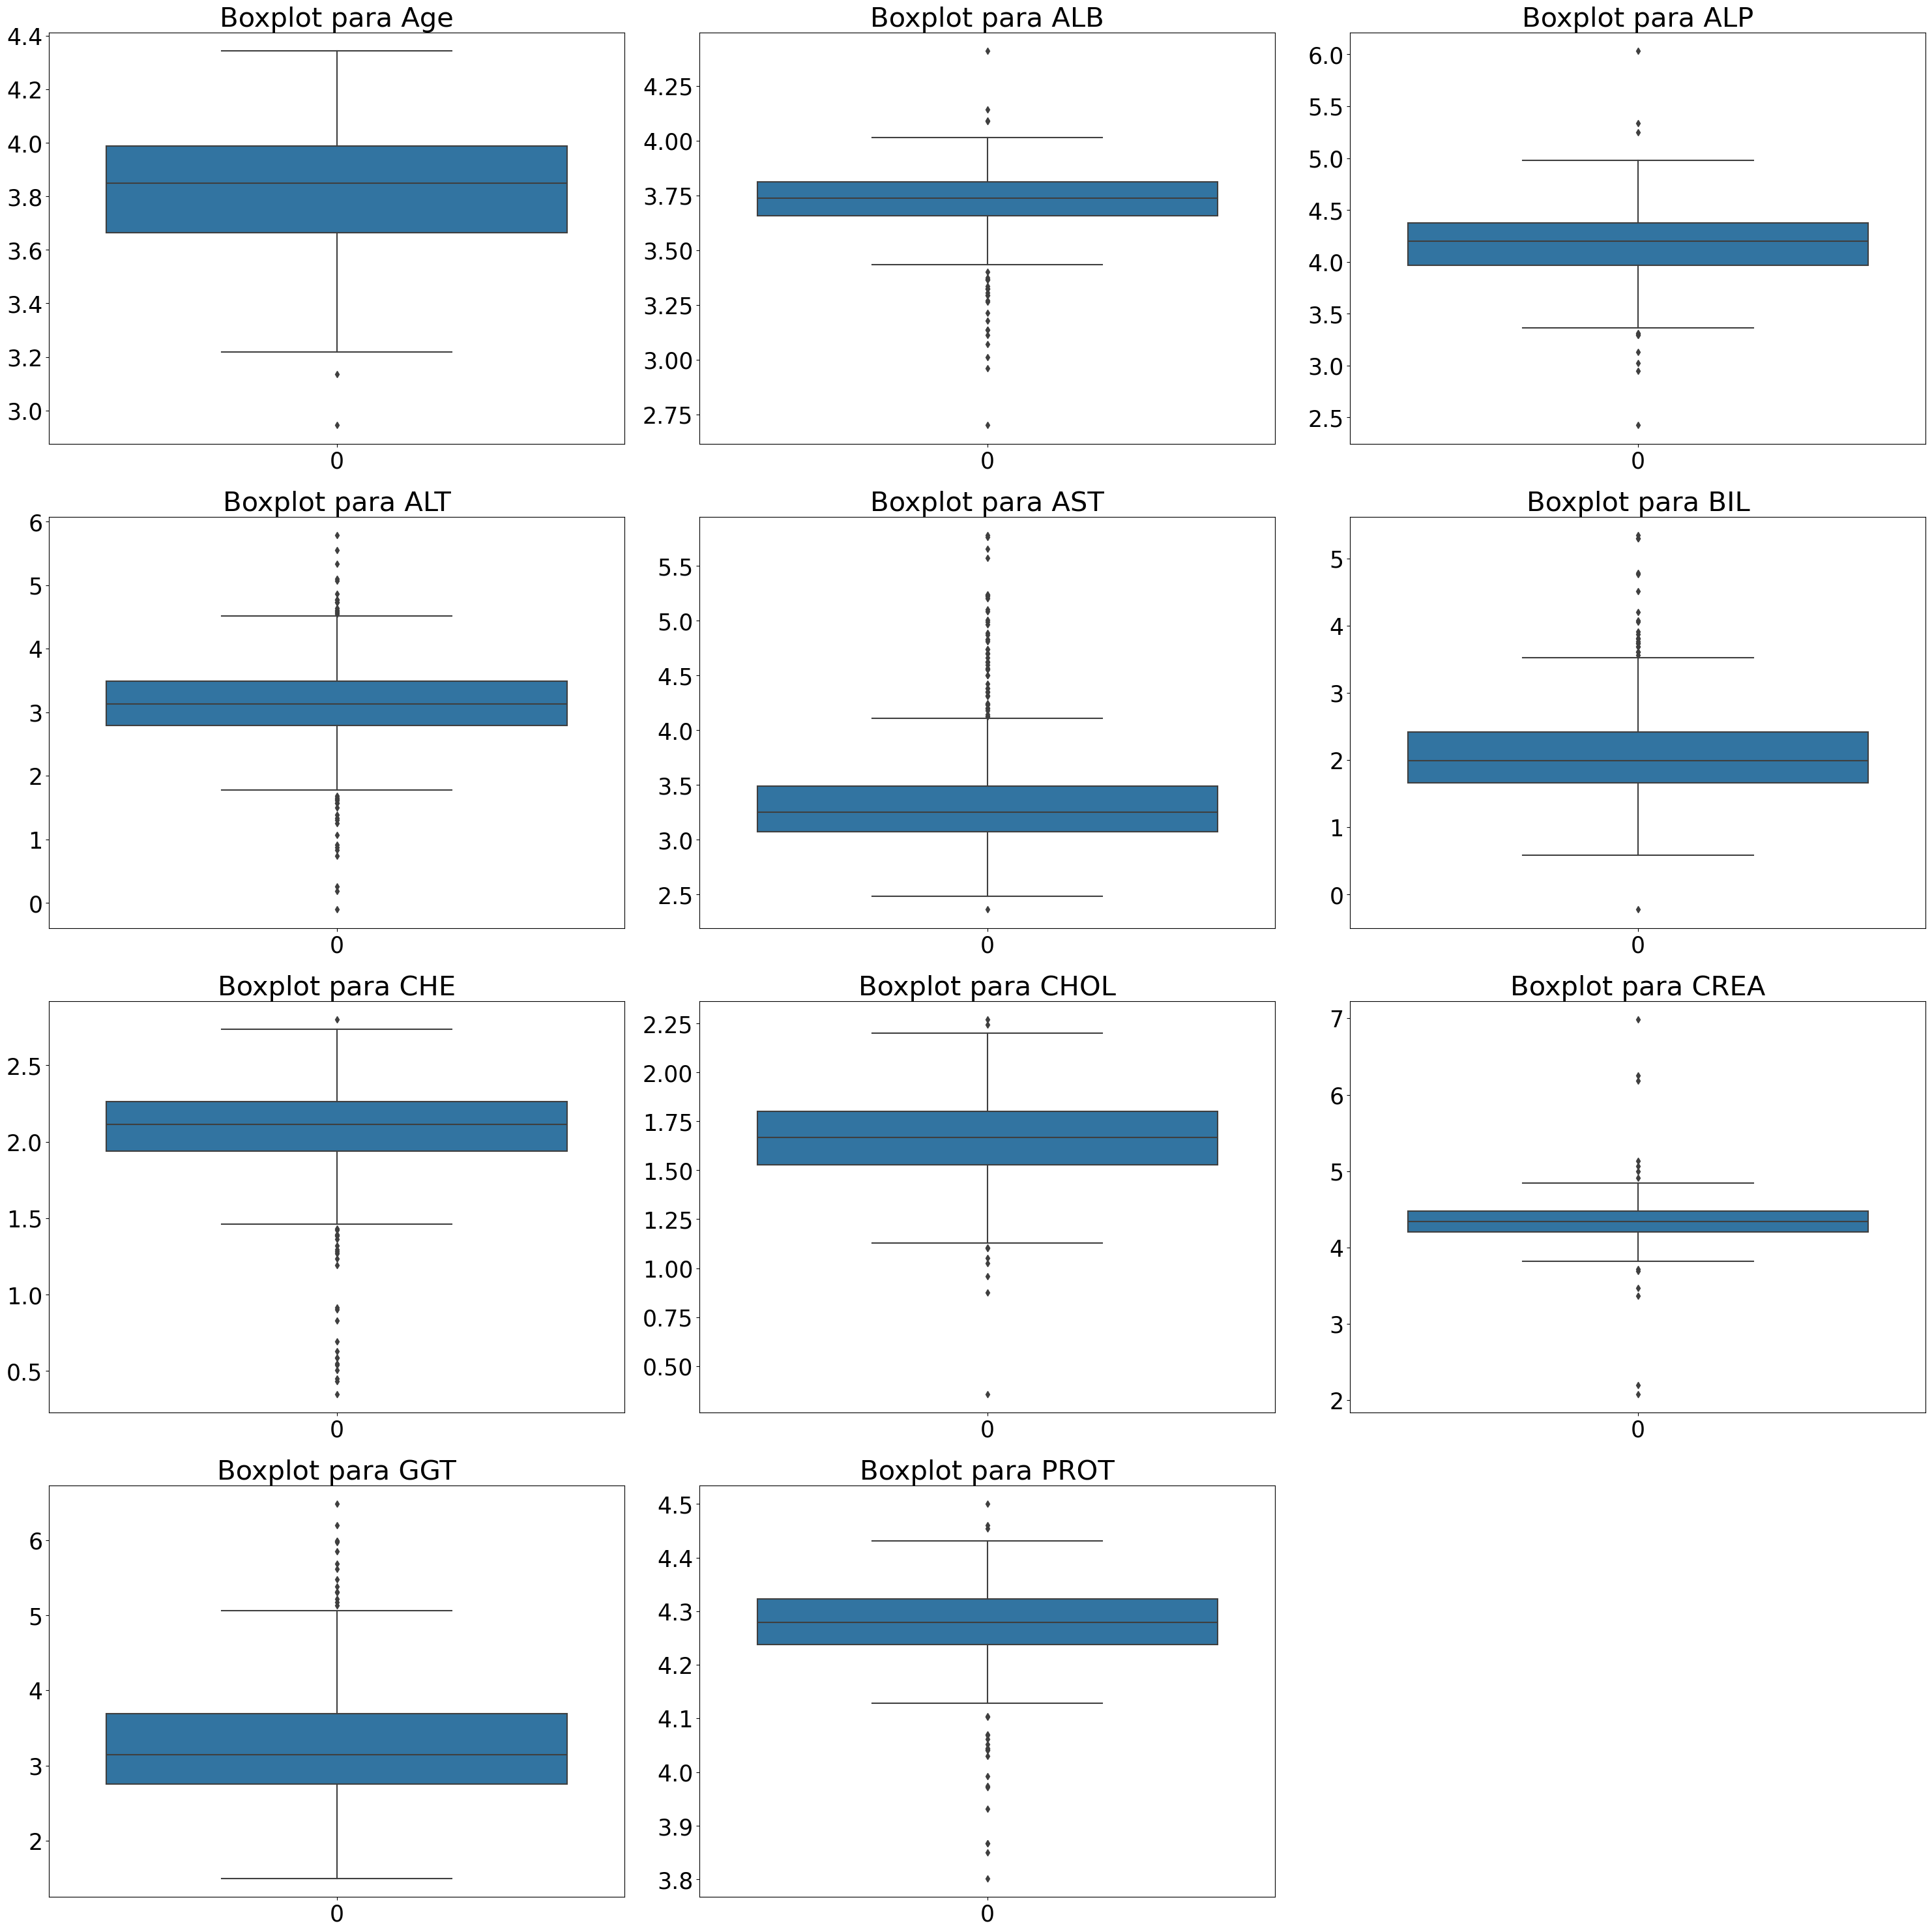

In [26]:
#graficamos los boxplots para las variables continuas despues de aplicar standart scale
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(30, 30))
for n, i in enumerate(columnas_numericas):
    plt.subplot(4, 3, n+1)
    sns.boxplot(X[i])
    plt.title('Boxplot para {}'.format(i))
    plt.tight_layout(pad=0.8)

- podemos ver que las variables están en una escala y normalizadas

### 2. Desarrolla un modelo regresión logística con validación cruzada usando 5-fold, con regularización Elastic Net.

In [27]:
#creamos un modelo de regresion logistica con parametros entregados
Cs = np.linspace(0.01, 5, num = 200)
l1_ratio = np.linspace(0, 1, num = 200)

regression_logic_elnet = LogisticRegressionCV(solver = 'saga', cv = 5, max_iter = 10000, penalty = 'elasticnet', Cs= Cs, l1_ratios=l1_ratio, n_jobs = 1)

In [28]:
regression_logic_elnet.fit(X_train, y_train) #entrenamos el modelo

LogisticRegressionCV(Cs=array([0.01      , 0.03507538, 0.06015075, 0.08522613, 0.11030151,
       0.13537688, 0.16045226, 0.18552764, 0.21060302, 0.23567839,
       0.26075377, 0.28582915, 0.31090452, 0.3359799 , 0.36105528,
       0.38613065, 0.41120603, 0.43628141, 0.46135678, 0.48643216,
       0.51150754, 0.53658291, 0.56165829, 0.58673367, 0.61180905,
       0.63688442, 0.6619598 , 0.68703518, 0.71211055, 0.737185...
       0.85427136, 0.85929648, 0.86432161, 0.86934673, 0.87437186,
       0.87939698, 0.88442211, 0.88944724, 0.89447236, 0.89949749,
       0.90452261, 0.90954774, 0.91457286, 0.91959799, 0.92462312,
       0.92964824, 0.93467337, 0.93969849, 0.94472362, 0.94974874,
       0.95477387, 0.95979899, 0.96482412, 0.96984925, 0.97487437,
       0.9798995 , 0.98492462, 0.98994975, 0.99497487, 1.        ]),
                     max_iter=10000, n_jobs=1, penalty='elasticnet',
                     solver='saga')

In [29]:
print('Valores optimos. C:', regression_logic_elnet.C_) #imprimimos los mejores parametros
print('L1 ratio:', regression_logic_elnet.l1_ratio_)

Valores optimos. C: [0.96286432]
L1 ratio: [0.]


In [30]:
coef_encontrados = pd.DataFrame() #guardamos los atributos con sus coficientes
coef_encontrados['atributos'] = list(regression_logic_elnet.feature_names_in_)
coef_encontrados['coeficientes'] = np.absolute(regression_logic_elnet.coef_[0])
coef_encontrados.sort_values('coeficientes', ascending=False)

,atributos,coeficientes
10,GGT,1.683580
5,AST,1.657942
12,suspect,1.244679
3,ALP,1.166802
4,ALT,1.009768
11,PROT,0.811963
8,CHOL,0.795649
6,BIL,0.749597
2,ALB,0.526990
1,Sex,0.471938


- Las variables mas importantes son: suspect, ALP y AST.
- La variable suspect tiene la mayor importancia lo que tiene sentido dado que indica los donors potenciales.
- Las variables ALP y AST están conectadas con la funcion hepática y podrían indicar daño de ella

In [31]:
y_pred_regression_logic_elnet = regression_logic_elnet.predict(X_test) #hacemos las predicciones
#imprimimos las metricas
print('Precision para el modelo de regresion logistica con elastic net:', precision_score(y_test, y_pred_regression_logic_elnet))
print('F1 score: ', f1_score(y_test, y_pred_regression_logic_elnet))
print('Accuracy:',accuracy_score(y_test, y_pred_regression_logic_elnet))
print('Recall:', recall_score (y_test, y_pred_regression_logic_elnet))
print('Classification report: \n' , classification_report (y_test, y_pred_regression_logic_elnet))

Precision para el modelo de regresion logistica con elastic net: 1.0
F1 score:  0.846153846153846
Accuracy: 0.9603960396039604
Recall: 0.7333333333333333
Classification report: 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       172
           1       1.00      0.73      0.85        30

    accuracy                           0.96       202
   macro avg       0.98      0.87      0.91       202
weighted avg       0.96      0.96      0.96       202



- El modelo tiene un rendimiento bastante bueno: f1 score es 0.87
- El modelo es mucho mejor en predicir los 0s (valor positivo) que los 1s(negativo), lo que se debe a la distribucion de la data entre target 0 y 1 
- Por eso recall, que es igual a 0.77 (habilidad de predecir correctamente los valores negativos), es mas bajo que la precision (la habilidad de predecir los valores positivos)

### XGBoosting

In [32]:
param_grid = {'reg_lambda': np.linspace(0, 2, num = 10, dtype = float), 
              'reg_alpha': np.linspace(0, 1, num = 10, dtype = float),
              'learning_rate': np.linspace(0.1, 10, num = 20, dtype = float)}
xgboost_base = XGBClassifier()

In [33]:
grid_xgboost = GridSearchCV(xgboost_base, param_grid=param_grid, cv = 5, n_jobs = 1)

In [34]:
grid_xgboost.fit(X_train, y_train) #entrenamos el modelo de busqueda de parametros para xgboosting

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
        2.70526316,  3.22631579,  3.74736842,  4.26842105,  4.78947368,
        5.31052632,  5.83157895,  6.35263158,  6.87368421,  7.39473684,
        7.91578947,  8.43684211,  8.95789474,  9.47894737, 10.        ]),
                         'reg_alpha': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                         'reg_lambda': array([0.        , 0.22222222, 0.44444444, 0.66666667, 0.88888889,
       1.11111111, 1.33333333, 1.55555556, 1.77777778, 2.        ])})

In [35]:
print('mejores parametros: ', grid_xgboost.best_params_) #imprimimos los mejores parametros y guardamos el mejor modelo
mejor_modelo_xgb = grid_xgboost.best_estimator_

mejores parametros:  {'learning_rate': 0.6210526315789474, 'reg_alpha': 0.1111111111111111, 'reg_lambda': 0.8888888888888888}


In [36]:
y_pred_xgb = mejor_modelo_xgb.predict(X_test) #hacemos las predicciones

#imprimimos las metricas
print('Precision para el modelo de regresion logistica con elastic net:', precision_score(y_test, y_pred_xgb))
print('F1 score: ', f1_score(y_test, y_pred_xgb))
print('Accuracy:',accuracy_score(y_test, y_pred_xgb))
print('Recall:', recall_score (y_test, y_pred_xgb))
print('Classification report: \n' , classification_report (y_test, y_pred_xgb))

Precision para el modelo de regresion logistica con elastic net: 0.9285714285714286
F1 score:  0.896551724137931
Accuracy: 0.9702970297029703
Recall: 0.8666666666666667
Classification report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       172
           1       0.93      0.87      0.90        30

    accuracy                           0.97       202
   macro avg       0.95      0.93      0.94       202
weighted avg       0.97      0.97      0.97       202




- el modelo de XGBoosting tiene mejor rendimiento que el modelo de regresion logística: f1 score es mayor (0.87 vs 0.9)
- este modelo es mucho mejor prediciendo los valores 1 comparandolo con el modelo anterior
- recall del modelo xgboosting es mas alto que el del modelo lineal (0.77 vs 0.87) 
- precision, igual que en el modelo anterior, es mas alto que recall (0.93 vs 0.87)
- En general, el modelo XGBoosting demuestra mejor desempeño en general tanto como en la prediccion de los valores negativos.

<BarContainer object of 13 artists>

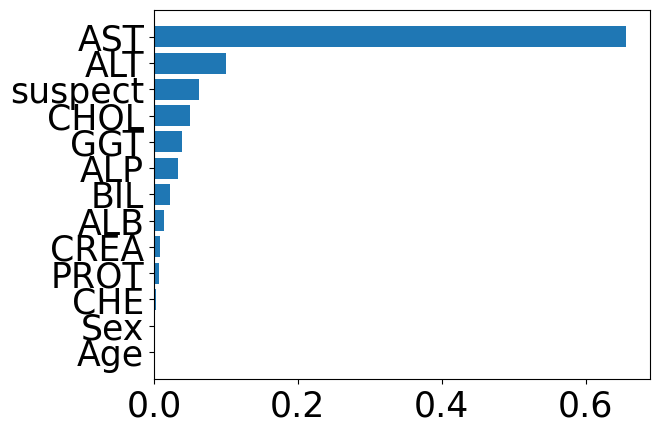

In [37]:
#mostramos la importancia de los atributos
idx_sort = np.argsort(mejor_modelo_xgb.feature_importances_)
plt.barh(y=mejor_modelo_xgb.feature_names_in_[idx_sort], width=mejor_modelo_xgb.feature_importances_[idx_sort])

- las variables AST y suspect están entre los 3 mejores atributos en ambos modelos
- la variable suspect tiene menos importancia en el modelo XGBoosting que en el modelo lineal. Esto puede ser porque el segundo modelo predice bastante bien los valores negativos y positivos, pero el modelo lineal - solo los valores positivos. Debe ser que para predecir los valores negativos otras variables son mas importante.